### solve the linearized dynamics of the cart-pull mechanism


below is the solution with equations that have been linearized about q1 = 0

In [176]:
using JuMP, Gurobi

#define initial and final states, x
x0 = [0 pi 0 0]' 
xf = [3 pi 0 0]'   #wind up at the same angle, but 


"""
linearize the dynamics of the cart pull mechanism through the small angle assumption -> first term
in taylor series expansion for sin(q) and cos(q)

inputs:
    x0 = [q₁ q₂ q₁dot q₂dot]'      #initial system state
    xf = [q₁ q₂ q₁dot q₂dot]'      #final system state
    tf = [sec]                     #time to get to final state
    h =  [sec]                     #time between collocation points

outputs:
    path = [4xk]                   #state matrix that specifies path 
"""
function SolvLinearizedCartPull(x0, xf, tf, h, itype = "forwardEuler")
    
    #define model
    m = Model(solver = GurobiSolver(OutputFlag=0))
    T = 0:h:tf                   #time vector
    K = length(T)                 #number of collocation points
    @variable(m,    x[1:4,1:K])   #system state at discrete times
    @variable(m, xdot[1:4,1:K])   #derivative of system state at discrete times
    @variable(m,    u[1:1,1:K])   #control input to system along q1

    #boundry constraints - initial and final state
    @constraint(m, x[:,1] .== x0)
    @constraint(m, x[:,K] .== xf)
    
    #path constraints
    
    #q₁ limits
#     xlower = -1
#     xupper =  4
#     for k in 1:K
#         @constraint(m, xlower <= x[1,k])
#         @constraint(m, x[1,k] <= xupper)
#     end
    
#     #q₂ limits
#      q2lower =  .5
#      q2upper =  -.5
    q2lower =   pi + .5
    q2upper =   pi - .5
    for k in 1:K
        @constraint(m, q2lower <= x[2,k])
        @constraint(m, x[2,k] <= q2upper)
    end
    
    
    #dynamics (path) constraints, integral form
    
    #model constants
    l = 1         #length of arm
    m1 = 3        #mass of cart
    m2 = 1        #mass of pendulum point mass
    g = 9.81
    linAngle = pi #the q2 angle we linearize the system about 
    
    
    #setup the dynamics constraints linearized about q1 = 0
    if linAngle == 0
        for k in 1:K
            #notes - linearized system with first term in taylor series, and neglected coreolis acceleration
            @constraint(m,xdot[1,k] == x[3,k])
            @constraint(m,xdot[2,k] == x[4,k])
            @constraint(m,xdot[3,k] == u[1,k] + m2*g*1*x[2,k] / m1) 
            @constraint(m,xdot[4,k] == -u[1,k]  -(m1 + m2)*g*x[2,k] / m1) 

        end
    end
    
    if linAngle == pi
        for k in 1:K
            #notes - linearized system with first term in taylor series, and neglected coreolis acceleration
            @constraint(m,xdot[1,k] == x[3,k])
            @constraint(m,xdot[2,k] == x[4,k])
            @constraint(m,xdot[3,k] == u[1,k]  + m2*g*1*x[2,k] / m1) 
            @constraint(m,xdot[4,k] == u[1,k]  +(m1 + m2)*g*x[2,k] / m1) 

        end
    end

    if itype == "forwardEuler" 
        #add forward euler dynamics constraint
        for k in 1:K-1
            @constraint(m, x[:,k+1] .== x[:,k] + h*xdot[:,k])
        end
        
    elseif itype == "backwardEuler"
        for k in 1:K-1
             #add backwards euler dynamics constraint
            @constraint(m, x[:,k+1] .== x[:,k] + .5*h*(xdot[:,k] + xdot[:,k+1]))
        end     
    end

    # minimize 2-norm (THIS IS LEAST-SQUARES)
    #@objective(m, Min, .5*h*sum(u[1:end-1].^2 + u[2:end].^2))
    @objective(m, Min, sum(u.^2) ) #+ sum(x[2,:]).^2))
    solve(m)
    #print(m)
    
    control = getvalue(u)
    xopt = getvalue(x)
    xdotopt = getvalue(xdot)
    
    return (control, xopt,xdotopt)
end


#notes: 
# - should we be using a regularizer, and on what variables?  

SolvLinearizedCartPull

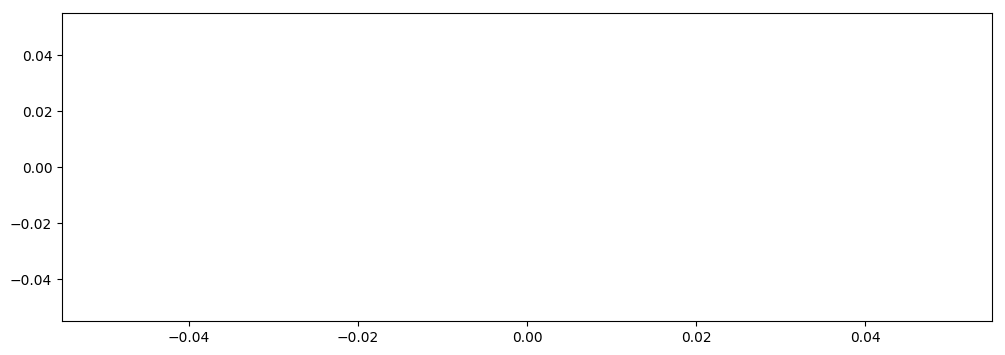

Academic license - for non-commercial use only


In [177]:

(c,x,xdot) = SolvLinearizedCartPull(x0,xf,3,.01)

using PyPlot
figure(figsize=(12,4))
#plot(c[1,:])
plot( x[1,:], "b.-", markersize=4)
plot(x[2,:],"r")
#legend("x","xdot")
#plot(xdot[1,:])
#plot(xdot[3,:])


process2CSV(x)

below, I define a library function which will convert the kinematics from a minimal set of generalized coordinates, to the maximal set that is required for my 3d ploting function:

In [122]:

(c,x,xdot) = SolvLinearizedCartPull(x0,xf,2,.01)

using PyPlot
figure(figsize=(12,4))
#plot(c[1,:])
plot( x[1,:], "b.-", markersize=4)
plot(x[2,:],"r")
#legend("x","xdot")
#plot(xdot[1,:])
#plot(xdot[3,:])


process2CSV(x)

4×401 Array{Float64,2}:
 -0.0      -0.0       0.0125477   0.0369404  …  2.96393  2.98774    3.0    
 -3.14159  -3.14159  -3.13213    -3.1139        3.11472  3.13241    3.14159
 -0.0       1.25477   2.43927     3.55635       2.38122  1.22595   -0.0    
 -0.0       0.94658   1.82289     2.63277       1.76837  0.918658  -0.0    

below are several numerical integration schemes, so that we can simulate the results of the optimization in forward dynamics

In [41]:
"""takes a 3x3 rotation matrix and converts it to a 4x1 array of euler parameters"""
function A2P(A::Array) 
  e0 = sqrt((trace(A) + 1)/4)
  if e0 != 0
    e1 = (A[3,2] - A[2,3])/(4*e0)
    e2 = (A[1,3] - A[3,1])/(4*e0)
    e3 = (A[2,1] - A[1,2])/(4*e0)
  end

  if e0 == 0  #implies Χ = π
    #figure out which e terms are non-zero
    e1flag = false; e2flag = false; e3flag = false;
    if A[1,1] + 1 != 0  e1flag = true end
    if A[2,2] + 1 != 0  e2flag = true end
    if A[3,3] + 1 != 0  e3flag = true end

    if e1flag
      e1 = sqrt((A[1,1] + 1)/2)
      e2 = (A[2,1] + A[1,2])/(4*e1)
      e3 = (A[3,1] + A[1,3])/(4*e1)
    elseif e2flag
      e2 = sqrt((A[2,2] + 1)/2)
      e1 = (A[2,1] + A[1,2])/(4*e2)
      e3 = (A[3,2] + A[2,3])/(4*e2)
    elseif e3flag
      e3 = sqrt((A[3,3] + 1)/2)
      e1 = (A[3,1] + A[1,3])/(4*e3)
      e2 = (A[3,2] + A[2,3])/(4*e3)
    else
      warn("something is wrong with A value  $A ")
    end
  end

  p = [e0 e1 e2 e3]'
end

#principle rotations
Rx(Θ) = [1 0 0 ; 0 cos(Θ) -sin(Θ) ; 0 sin(Θ) cos(Θ)]
Ry(Θ) = [ cos(Θ) 0 sin(Θ) ; 0 1 0 ; -sin(Θ) 0 cos(Θ)]
Rz(Θ) = [ cos(Θ) -sin(Θ) 0 ; sin(Θ) cos(Θ) 0  ; 0 0 1]


Rz (generic function with 1 method)

In [76]:
using DataFrames
"""
convert state vector x for the cart pull problem from a minimal set of generalized coordinates to a
maximal set of cartesian coordinates using euler parameters to describe rotation. additionally, 
rotations will be made so that things look right in unity

inputs:
    x - state vector resulting from from our control optimization
    fln - string of file location
outputs:
    csv - write a csv to the proper location
    
assumptions:
-This code assumes the original simulation is resampled at 30Hz so the visualization timing is correct
- left handed coordinates as defined in unity:
    * y is up
    * x is left
    * z is out of the page

movement of the cart occures along the x, and rotation of the pendulum occures about z axis
"""
function process2CSV(x,path = "./pullCartVis3D/Assets/Data/data.csv")
    
    #extract state, we only need q1 and q2
    x = x[1:2,:]
    
    #build out fill state matrix  xFull = [r₁;r₂;p₁;p₂]
    nb = 2;
    xFull = zeros(7*nb, size(x)[2])  
    
    #place location parameters appropriately
    xFull[1,:] = x[1,:]
    xFull[4,:] = x[1,:]
    xFull[6,:] = .15*ones(size(x)[2],1)                 #unity compensation
    
    #place orientation parameters appropriately
    for i in range(1,size(x)[2])  
        xFull[7:10,i]   = A2P(Rx(pi/2)*eye(3))          #unity compensation
        xFull[11:14,i] = A2P(Rx(pi/2)*Ry(x[2,i]))       #unity compensation
    end
        
    #print to CSV
    xFull = convert(DataFrame, xFull)
    writetable(path,xFull)
end
    

#future:
"""
linearly interpolate between points on a grid u[k]
"""
function interpolate(u::Array,h::Float64,t::Float64)
    if ndims(u) == 1 u = reshape(u,1,length(u)) end   #robust to 1d arrays
    k = Int(floor(t/h) + 1)
    if k == size(u)[2] return u[k] end              #you sampled at the exact last point
    deltat = t - (k-1)*h;                            #correcting for 1 index
    u_t = u[k] + deltat*(u[k+1]-u[k])/h
    return u_t
end
    
"""
resample an x array at the requested sample rate
"""
function resample(x,h0,h1)
    tf = h0*(size(x)[2] - 1)
    colsNew = Int(floor(tf/h1) + 1)
    xnew = zeros(size(x)[1],colsNew)
    for row in 1:size(x)[1]
        for col in 1:colsNew
                xnew[row,col] = interpolate(x[row:row,:],h0,(col-1)*h1)
        end
    end
    return xnew
end
    


resample

In [21]:
u = [0 1 2 3 4]
interpolate(u,1.0,3.3)

x = resample(u,.1,.05)


1×9 Array{Float64,2}:
 0.0  0.5  1.0  1.5  2.0  2.5  3.0  3.5  4.0

In [17]:
u[2]

1

In [128]:
process2CSV(x)

Once we perform a trajectory optimization with models of different complexity / that make different assumptions, it would be interesting to see what the forward dynamics of the system would look like for the control that has been specified. 

notes:

**what we have working:**
* a forward euler based solver with highly linearized dynamics, that is capable of solving 
    - optimal control of a non-inverted pendulum
    - optimal control of a swing up problem. 
    
* a unity visualizer that will display any movement of the pendulum, when given an input vector x


**Things we still need to do:**
- a proper introduction to for all these sections...
- this includes a proper derivation of the dynamics of the cart pull system
- explore what happens if we put simple path constraints on the existing system
- implement full direct collocation (with backwards euler / trapozoid method) 

**our modeling framework: levels of complexity and assumptions - each assumption removes a level of complexity in the dynamics**    
1. assumptions - small angles and quazi-static
   model - quadratic objective with Linear constraints (this is what we have working)
2. assumptions - small angles
   model - quadratic objective with quadratic constraints(to be implemented) - should solve with gurobi
3. no assumptions - full dynamics 
   model - quadratic objective with non-linear constraints - NLP - requires IPOPT library to solve


**order of integration method**
0. zero order
1. 1st order (trapezoid)
2. 2nd order or higher (math gets pretty intense)


**Implement a numerical solver to solve the system as an IVP** - I think that using a numerical solver to take the u(t) calculated by the method and then forward integrating it with the Real dynamics would be an interesting way to assess how bad each of the assumptions actually impacts the performance of this simple system. 
        
        
        
**Things we could do:**
* explore simpsons-hermite transcription (higher order method than trapozoid)
* explore the effect of ZOH, since this is what is actually possible as a control signal
* explore exotic path constraints (swing up, but avoid these obsticles while you go through
* alternative objective, robust control
* set waypoints  to hit / follow a trajectory
* have a tradeoff between a desired trajectory and minimizing a cost
* double pendulum


    

**proposed organization of report:**

* Introduction
```julia
for model in increasing complexity```
    * Mathematical Model
    * Solution
    * Results / discussion
```julia
end```
* Conclusion


In [22]:
"""
treat the cart pull problem as an initial value problem and numerically integrate forward in time 
with the full dynamics to get the best estimate of the "real" trajectory

the approach will be a simple forward euler integrator

inputs:
    x0 =   [q₁ q₂ q₁dot q₂dot]'      #initial system state
    u[k] = [u₁ u₂ ... uₙ]            #discrete sampled control value
    tf =   [sec]                     #time between collocation points
    h =    [sec]                     #time between collocation points
    method = str                     #level of assumptions being made 

outputs:
    x[k] = [4 x n]                   
    

"""
function pullCartForwardDynamics(x0,u,tf,h,method = 1)
    #setup
    tspan = 0:h:tf
    x =    zeros(4,length(tspan)+1)
    xdot = zeros(4,length(tspan)+1)
    x[:,1] = x0
    
    #forward euler integration
    for (k,t) in enumerate(tspan)
        xdot[:,k] = calcxdot(x[:,k],u,h,method) 
        x[:,k+1]  = x[:,k] + h*xdot[:,k]
    end
    
    return x
end

"""
calcuate xdot from the specified system dynamics using forward euler
"""
function calcxdot(x,u,h,method)
    #model constants
    l = 1         #length of arm
    m1 = 1        #mass of cart
    m2 = 1        #mass of pendulum 
    g = 9.81
    
    #
    u = 0
    
    xdot = zeros(4,1)
    
    #calculate xdot    
    q1 = x[1,1] ; q2 = x[2,1] ; q1dot = x[3,1] ; q2dot = x[4,1]
    xdot[3,1] =  (l*m2*sin(q2)*q2dot^2 + u + m2*g*cos(q2)*sin(q2)) / (m1 + m2*(1-cos(q2)^2))
    xdot[4,1] = -(l*m2*cos(q2)*sin(q2)*q2dot^2 + u*cos(q2) + (m1 + m2)*g*sin(q2))/ (l*m1 + l*m2*(1-cos(q2)^2))
    
    #forward euler step
    xdot[1:2,1] = x[3:4,1] + h*xdot[3:4,1]
    
    return xdot
    
end

calcxdot

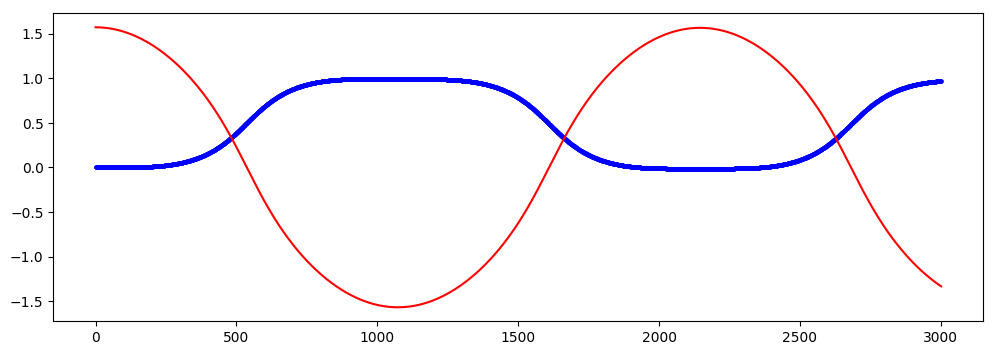

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000002F5ABD68>

In [55]:
x0 = [0 pi/2 0 0]'
x = pullCartForwardDynamics(x0,0,3,.001,1)
using PyPlot
figure(figsize=(12,4))
#plot(c[1,:])
plot( x[1,:], "b.-", markersize=4)
plot(x[2,:],"r")

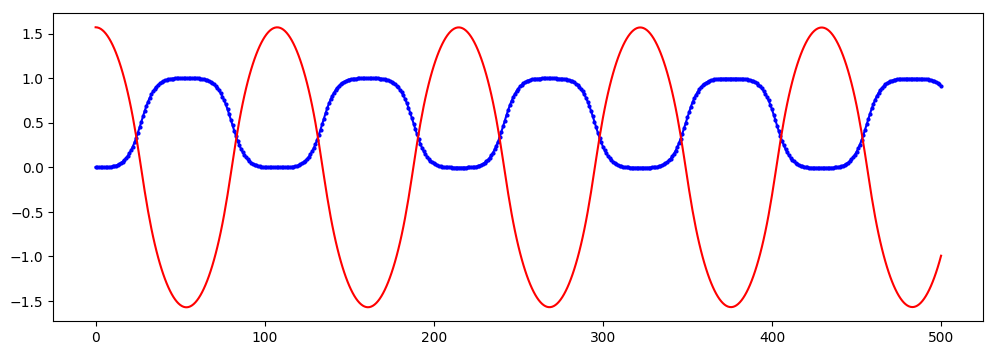

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000218939B0>

In [49]:
 x = resample(x,.0001,.02)
using PyPlot
figure(figsize=(12,4))
#plot(c[1,:])
plot( x[1,:], "b.-", markersize=4)
plot(x[2,:],"r")

In [42]:
process2CSV(x)

### solve the non-linear dynamics with ipopt
- the full dynamics are highly nonlinear and must be solved using a non linear program solver - ipopt

In [69]:
using JuMP, PyPlot, Ipopt

#define initial and final states, x
x0 = [0 0 0 0]' 
xf = [3 pi 0 0]'   #wind up at the same angle, but 

"""
solve the cart pull problem using direct collocation and full dynamics

inputs:
    x0 = [q₁ q₂ q₁dot q₂dot]'      #initial system state
    xf = [q₁ q₂ q₁dot q₂dot]'      #final system state
    tf = [sec]                     #time to get to final state
    h =  [sec]                     #time between collocation points

outputs:
    path = [4xk]                   #state matrix that specifies path 
"""
function SolvFullCartPull(x0, xf, tf, h, itype = "backwardEuler")
    
    #define model
    m = Model(solver = IpoptSolver(print_level=0))
    T = 0:h:tf                   #time vector
    K = length(T)                 #number of collocation points
    @variable(m,    x[1:4,1:K])   #system state at discrete times
    @variable(m, xdot[1:4,1:K])   #derivative of system state at discrete times
    @variable(m,    u[1:1,1:K])   #control input to system along q1

    #boundry constraints - initial and final state
    @constraint(m, x[:,1] .== x0)
    @constraint(m, x[:,K] .== xf)

    
    #model constants
    l = 1         #length of arm
    m1 = 3        #mass of cart
    m2 = 1        #mass of pendulum point mass
    g = 9.81
    
    
    #setup the full dynamics constraints
    for k in 1:K
        @constraint(m,xdot[1,k] == x[3,k])                      #this step could be wrong!!! I may need to integrate here
        @constraint(m,xdot[2,k] == x[4,k])                      #look here for an issue
         #calculate xdot    
        q1 = x[1,k] ; q2 = x[2,k] ; q1dot = x[3,k] ; q2dot = x[4,k]
        @NLconstraint(m,xdot[3,k] ==  (l*m2*sin(q2)*q2dot^2 + u[1,k] + m2*g*cos(q2)*sin(q2)) /
                                    (m1 + m2*(1-cos(q2)^2)))
        @NLconstraint(m,xdot[4,k] == -(l*m2*cos(q2)*sin(q2)*q2dot^2 + u[1,k]*cos(q2) + (m1 + m2)*g*sin(q2))/
                                    (l*m1 + l*m2*(1-cos(q2)^2)))

    end
    

    if itype == "forwardEuler" 
        #add forward euler dynamics constraint
        for k in 1:K-1
            @constraint(m, x[:,k+1] .== x[:,k] + h*xdot[:,k])
        end
        
    elseif itype == "backwardEuler"
        for k in 1:K-1
             #add backwards euler dynamics constraint
            @constraint(m, x[:,k+1] .== x[:,k] + .5*h*(xdot[:,k] + xdot[:,k+1]))
        end     
    end

    # minimize 2-norm (THIS IS LEAST-SQUARES)
    #@objective(m, Min, .5*h*sum(u[1:end-1].^2 + u[2:end].^2))
    @objective(m, Min, sum(u.^2) ) #+ sum(x[2,:]).^2))
    solve(m)
    #print(m)
    
    control = getvalue(u)
    xopt = getvalue(x)
    xdotopt = getvalue(xdot)
    
    return (m,control, xopt,xdotopt)
end


SolvFullCartPull

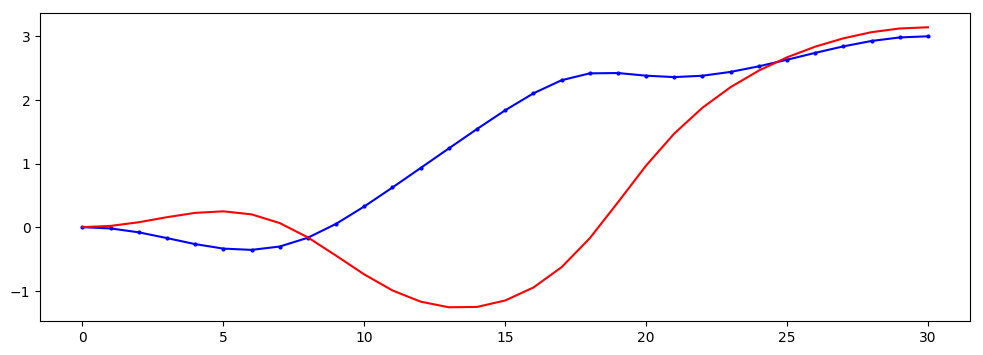

In [77]:
 m,u,x,xdot = SolvFullCartPull(x0, xf,3, .1)

using PyPlot
figure(figsize=(12,4))
#plot(c[1,:])
plot( x[1,:], "b.-", markersize=4)
plot(x[2,:],"r")
#legend("x","xdot")
#plot(xdot[1,:])
#plot(xdot[3,:])


#output to visualizer
x = resample(x,.1,.02)
process2CSV(x)

#### full dynamics, but incorporating  two levels of backwards euler
* the first methods seemed to work , but the constraints on velocity were simply that they should be equal in x and xdot. I think this may be causing an issue, and I didn't realize it until I wrote the forward euler integrator. 
* so this time, I'll implement both levels of the backwards euler integration constraint


In [ ]:
"""
solve the cart pull problem using direct collocation and full dynamics

inputs:
    x0 = [q₁ q₂ q₁dot q₂dot]'      #initial system state
    xf = [q₁ q₂ q₁dot q₂dot]'      #final system state
    tf = [sec]                     #time to get to final state
    h =  [sec]                     #time between collocation points

outputs:
    path = [4xk]                   #state matrix that specifies path 
"""
function SolvFullCartPull(x0, xf, tf, h, itype = "backwardEuler")
    
    #define model
    m = Model(solver = IpoptSolver(print_level=0))
    T = 0:h:tf                   #time vector
    K = length(T)                 #number of collocation points
    @variable(m,    x[1:4,1:K])   #system state at discrete times
    @variable(m, xdot[1:4,1:K])   #derivative of system state at discrete times
    @variable(m,    u[1:1,1:K])   #control input to system along q1

    #boundry constraints - initial and final state
    @constraint(m, x[:,1] .== x0)
    @constraint(m, x[:,K] .== xf)

    
    #model constants
    l = 1         #length of arm
    m1 = 3        #mass of cart
    m2 = 1        #mass of pendulum point mass
    g = 9.81
    
    
    #setup the full dynamics constraints
    for k in 1:K
        @constraint(m,xdot[1,k] == x[3,k])                      #this step could be wrong!!! I may need to integrate here
        @constraint(m,xdot[2,k] == x[4,k])                      #look here for an issue
         #calculate xdot    
        q1 = x[1,k] ; q2 = x[2,k] ; q1dot = x[3,k] ; q2dot = x[4,k]
        @NLconstraint(m,xdot[3,k] ==  (l*m2*sin(q2)*q2dot^2 + u[1,k] + m2*g*cos(q2)*sin(q2)) /
                                    (m1 + m2*(1-cos(q2)^2)))
        @NLconstraint(m,xdot[4,k] == -(l*m2*cos(q2)*sin(q2)*q2dot^2 + u[1,k]*cos(q2) + (m1 + m2)*g*sin(q2))/
                                    (l*m1 + l*m2*(1-cos(q2)^2)))

    end
    
     #forward euler step
    
    xdot[1:2,1] = x[3:4,1] + h*xdot[3:4,1]
    
    elseif itype == "backwardEuler"
        for k in 1:K-1
             #add backwards euler dynamics constraint
            @constraint(m, x[:,k+1] .== x[:,k] + .5*h*(xdot[:,k] + xdot[:,k+1]))
        end     
    end

    # minimize 2-norm (THIS IS LEAST-SQUARES)
    #@objective(m, Min, .5*h*sum(u[1:end-1].^2 + u[2:end].^2))
    @objective(m, Min, sum(u.^2) ) #+ sum(x[2,:]).^2))
    solve(m)
    #print(m)
    
    control = getvalue(u)
    xopt = getvalue(x)
    xdotopt = getvalue(xdot)
    
    return (m,control, xopt,xdotopt)
end
